In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import lightgbm as lgb

# Evaluación
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score

# Gráficas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Base de datos de entrenamiento
df = pd.read_csv('Train_limpia.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)

# Sest de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(df.drop("Survived", axis = 1),
                                                  df.Survived, test_size=0.3, random_state=42)

# Base de datos para prueba sin clasificaciones
test = pd.read_csv('Test_limpia.csv')

# Instancia con valor nulo de edad
r, _ = np.where(test.isna())
test = test.dropna(axis=0,how = "any")

y_test = pd.read_csv('submission_test.csv')
y_test = y_test.drop(r[0]) #valor nulo de edad
y_test = np.array(y_test.Survived)


# Variación hiperparámetros

## Funciones

In [ ]:
# Número de árboles de decisión
def get_models_est(trees):
	models = dict()
	for n in trees:
		models[str(n)] = LGBMClassifier(n_estimators=n, force_row_wise=True, verbose = -1)
	return models

# Profundidad máxima del modelo y número de hojas
def get_models_depth(d):
	models = dict()
	for i in range(1,d+1):
		models[str(i)] = LGBMClassifier(n_estimators=60, max_depth=i, num_leaves=int(np.ceil(2**i*0.6)), force_row_wise=True, verbose = -1)
	return models

# Tipos de boost
def get_models_boost():
  models = dict()
  types = ['gbdt', 'dart', 'goss']
  for t in types:
    models[t] = LGBMClassifier(n_estimators=60, max_depth=3, num_leaves=int(np.ceil(2**3*0.6)),
                               boosting_type=t, force_row_wise=True, verbose = -1)
  return models

# Distintos valores de learning rate (muy pequeño a muy grande)
def get_models_lr(rates):
  models = dict()
  for r in rates:
    key = '%.4f' % r
    models[key] = LGBMClassifier(n_estimators=60, max_depth=3, num_leaves=int(np.ceil(2**3*0.6)),
                               boosting_type='gbdt', learning_rate=r, force_row_wise=True, verbose = -1)
  return models


# Fit y test de los modelos
def fit_model(models):
  results, names = list(), list()
  for name,model in models.items(): # selección de cada modelo
    model.fit(X_train, y_train) # entrenamiento
    y_pred = model.predict(X_val) # predicciones
    # medidas de aprendizaje
    results.append([accuracy_score(y_val, y_pred), precision_score(y_val, y_pred),
                    recall_score(y_val, y_pred), f1_score(y_val, y_pred)])
    names.append(name)

  results = pd.DataFrame(results) # tabla con resultados de todos los modelos
  results.columns = ['Accuracy', 'Precision','Recall','f-1']
  return results, names

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.drop("Survived", axis = 1),
                                                  df.Survived, test_size=0.1, random_state=42)

In [ ]:
y_train.shape

(800,)

## Num estimadores

Aunque se tengan buenos valores para las métricas con un mayor número de estimadores (>100), no se recomiendan estos valores ya que tiende a causar overfitting, por lo que, se buscará un número entre 50 y 100 que tenga los mejores valores.

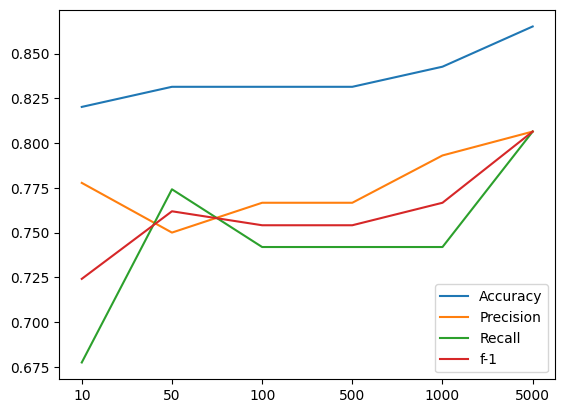

,Accuracy,Precision,Recall,f-1
0,0.820225,0.777778,0.677419,0.724138
1,0.831461,0.750000,0.774194,0.761905
2,0.831461,0.766667,0.741935,0.754098
3,0.831461,0.766667,0.741935,0.754098
4,0.842697,0.793103,0.741935,0.766667
5,0.865169,0.806452,0.806452,0.806452


In [ ]:
# Creación de modelos
models = get_models_est([10, 50, 100, 500, 1000, 5000])

# Entrenamiento de modelos
results_est, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_est)
plt.legend(results_est.columns)
plt.show()

results_est.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

Se observa que en este rango, el máximo local son 60 estimadores, con estos se obtienen buenos valores de las métricas de aprendizaje. Por lo que se seleccionan estos valores para nuestro posterior análisis.

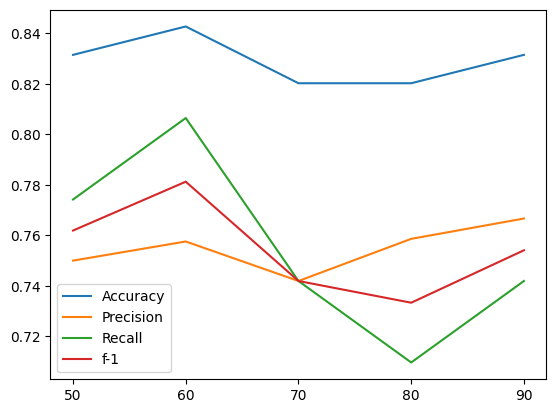

,Accuracy,Precision,Recall,f-1
0,0.831461,0.750000,0.774194,0.761905
1,0.842697,0.757576,0.806452,0.781250
2,0.820225,0.741935,0.741935,0.741935
3,0.820225,0.758621,0.709677,0.733333
4,0.831461,0.766667,0.741935,0.754098


In [ ]:
# Creación de modelos
models = get_models_est(np.arange(50,100, 10))

# Entrenamiento de modelos
results_est, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_est)
plt.legend(results_est.columns)
plt.show()

results_est.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

## Prof máxima y número de hojas

Observamos que el modelo se comporta mejor con una profundidad máxima de 12 o 3, además, se recomienda un max_depth menor para no provocar un sobreajuste. Por lo que se escoge una profundidad máxima de 3.

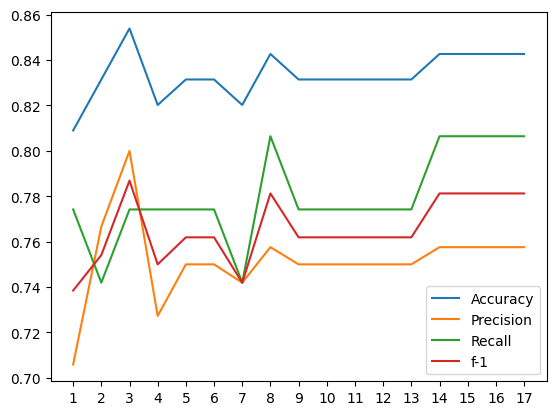

,Accuracy,Precision,Recall,f-1
0,0.808989,0.705882,0.774194,0.738462
1,0.831461,0.766667,0.741935,0.754098
2,0.853933,0.800000,0.774194,0.786885
3,0.820225,0.727273,0.774194,0.750000
4,0.831461,0.750000,0.774194,0.761905
5,0.831461,0.750000,0.774194,0.761905
6,0.820225,0.741935,0.741935,0.741935
7,0.842697,0.757576,0.806452,0.781250
8,0.831461,0.750000,0.774194,0.761905
9,0.831461,0.750000,0.774194,0.761905


In [ ]:
# Creación de modelos
models = get_models_depth(17)

# Entrenamiento de modelos
results_depth, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_depth)
plt.legend(results_depth.columns)
plt.show()

results_depth.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

## Tipo de boost

El tipo de boosting que obtiene mejores resultados es el de 'gbdt', el cual es el valor default del modelo.

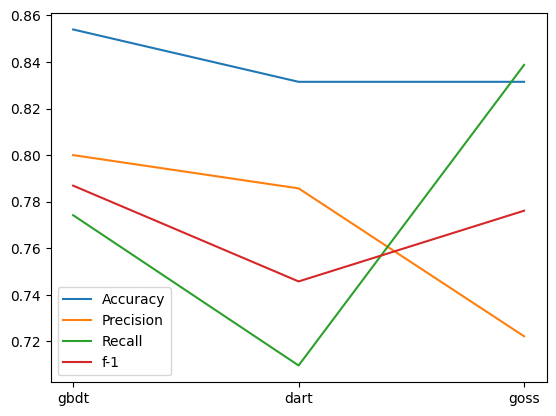

,Accuracy,Precision,Recall,f-1
0,0.853933,0.800000,0.774194,0.786885
1,0.831461,0.785714,0.709677,0.745763
2,0.831461,0.722222,0.838710,0.776119


In [ ]:
# Creación de modelos
models = get_models_boost()

# Entrenamiento de modelos
results_boost, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_boost)
plt.legend(results_boost.columns)
plt.show()

results_boost.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

## Learning rate

Con valores de learning rate de 0.01, 0.1 o 1 se comportan de manera similar en cuanto a las métricas de aprendizaje. Por lo que se hará un análisis centrado en este rango.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


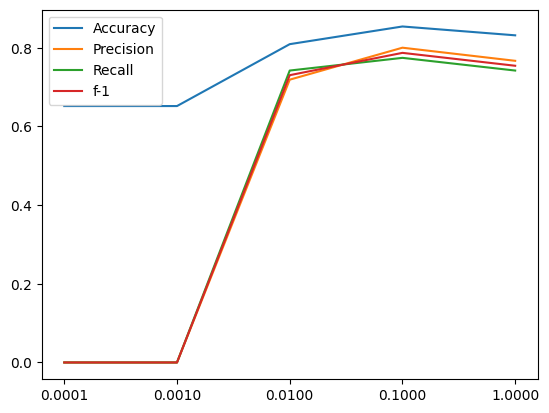

,Accuracy,Precision,Recall,f-1
0,0.651685,0.000000,0.000000,0.000000
1,0.651685,0.000000,0.000000,0.000000
2,0.808989,0.718750,0.741935,0.730159
3,0.853933,0.800000,0.774194,0.786885
4,0.831461,0.766667,0.741935,0.754098


In [ ]:
# Creación de modelos
models = get_models_lr([0.0001, 0.001, 0.01, 0.1, 1.0])

# Entrenamiento de modelos
results_lr, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_lr)
plt.legend(results_lr.columns)
plt.show()

results_lr.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

En esta búsqueda, obtenemos que un learning rate de 0.51 obtiene mejores valores de métricas de aprendizaje.

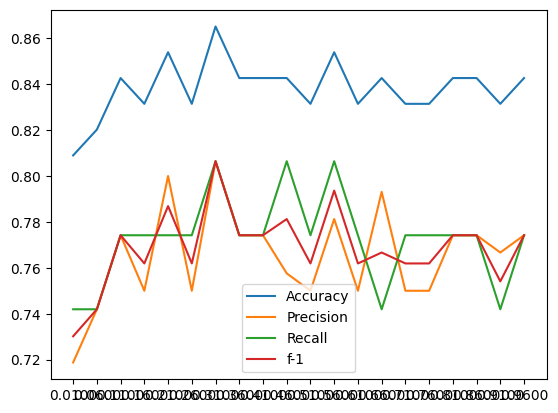

,Accuracy,Precision,Recall,f-1
0,0.808989,0.718750,0.741935,0.730159
1,0.820225,0.741935,0.741935,0.741935
2,0.842697,0.774194,0.774194,0.774194
3,0.831461,0.750000,0.774194,0.761905
4,0.853933,0.800000,0.774194,0.786885
5,0.831461,0.750000,0.774194,0.761905
6,0.865169,0.806452,0.806452,0.806452
7,0.842697,0.774194,0.774194,0.774194
8,0.842697,0.774194,0.774194,0.774194
9,0.842697,0.757576,0.806452,0.781250


In [ ]:
# Creación de modelos
lr = np.arange(0.01, 1.01, 0.05)
models = get_models_lr(lr)

# Entrenamiento de modelos
results_lr, names = fit_model(models)

# Gráficas de métricas de aprendizaje
plt.plot(names, results_lr)
plt.legend(results_lr.columns)
plt.show()

results_lr.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

In [ ]:
lr[10]

0.51

## Hiperparámetros seleccionados

En resumen, el modelo con los hiperparámetros seleccionados queda de la siguiente forma:

In [ ]:
model = LGBMClassifier(n_estimators=60, max_depth=3, num_leaves=int(np.ceil(2**3*0.6)),
                               boosting_type='gbdt', learning_rate=0.51, force_row_wise=True, verbose = -1)

# Distintos porcentajes de entrenamiento y validación

## Función

In [ ]:
# Fit y test de los modelos con distintos porcentajes de separación
def fit_model_val(split, model):
  results_train, results_val = list(), list()
  for i in split: # selección de cada % de separación
    X_train, X_val, y_train, y_val = train_test_split(df.drop("Survived", axis = 1),
                                                  df.Survived, test_size=i, random_state=42)
    model.fit(X_train, y_train) # entrenamiento

    y_pred_train = model.predict(X_train) # predicciones set de entrenamiento
    y_pred_val = model.predict(X_val) # predicciones set de validacion
    # métricas de aprendizaje (ambos sets)
    results_train.append([accuracy_score(y_train, y_pred_train), precision_score(y_train, y_pred_train),
                    recall_score(y_train, y_pred_train), f1_score(y_train, y_pred_train)])

    results_val.append([accuracy_score(y_val, y_pred_val), precision_score(y_val, y_pred_val),
                    recall_score(y_val, y_pred_val), f1_score(y_val, y_pred_val)])

  results_train = pd.DataFrame(results_train) # tabla con resultados de set de entrenamiento
  results_train.columns = ['Accuracy', 'Precision','Recall','f-1']

  results_val = pd.DataFrame(results_val) # tabla con resultados de set de validación
  results_val.columns = ['Accuracy', 'Precision','Recall','f-1']
  return results_train, results_val

In [ ]:
#model = LGBMClassifier(verbose = -1, boosting_type= "goss", max_depth= 3, learning_rate= 0.01, n_estimators= 60 )
split = np.arange(0.1, 0.91, 0.01)
results_train, results_val = fit_model_val(split, model)

## Métricas de aprendizaje

Métricas con el modelo anterior y distintos % de separación

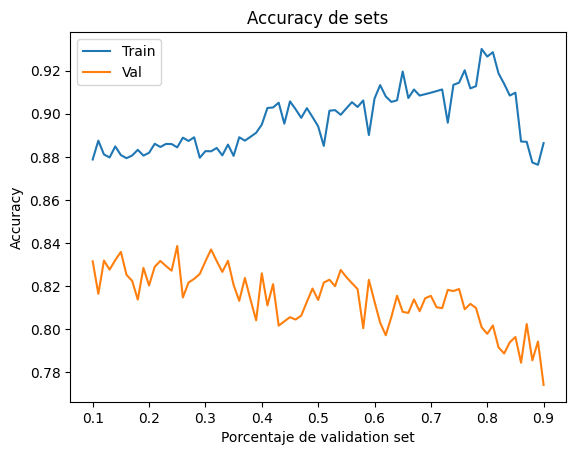

In [ ]:
# Accuracy
plt.plot(split, results_train.Accuracy)
plt.plot(split, results_val.Accuracy)
plt.legend(['Train','Val'])
plt.title('Accuracy de sets')
plt.ylabel('Accuracy')
plt.xlabel('Porcentaje de validation set')
plt.show()

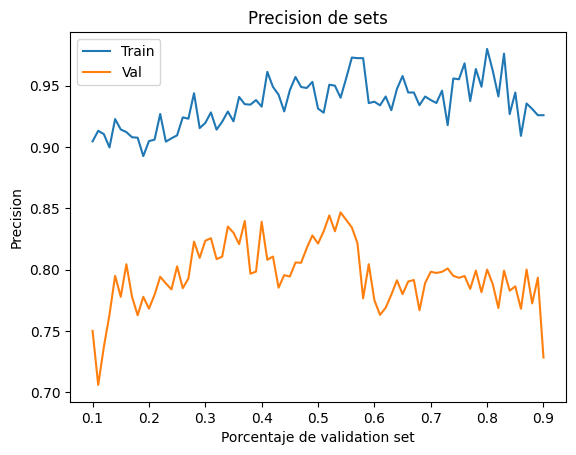

In [ ]:
# Precision
plt.plot(split, results_train.Precision)
plt.plot(split, results_val.Precision)
plt.legend(['Train','Val'])
plt.title('Precision de sets')
plt.ylabel('Precision')
plt.xlabel('Porcentaje de validation set')
plt.show()

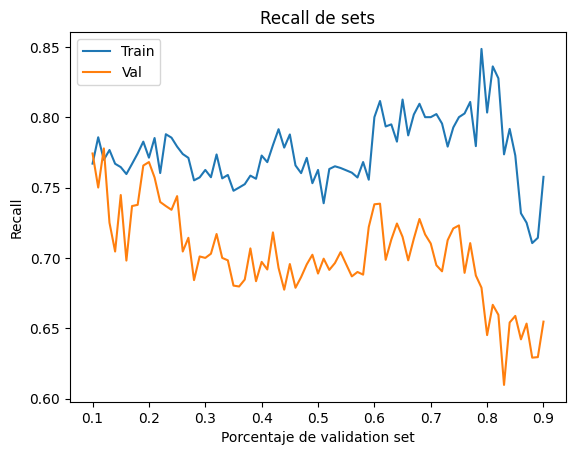

In [ ]:
# Recall
plt.plot(split, results_train.Recall)
plt.plot(split, results_val.Recall)
plt.legend(['Train','Val'])
plt.title('Recall de sets')
plt.ylabel('Recall')
plt.xlabel('Porcentaje de validation set')
plt.show()

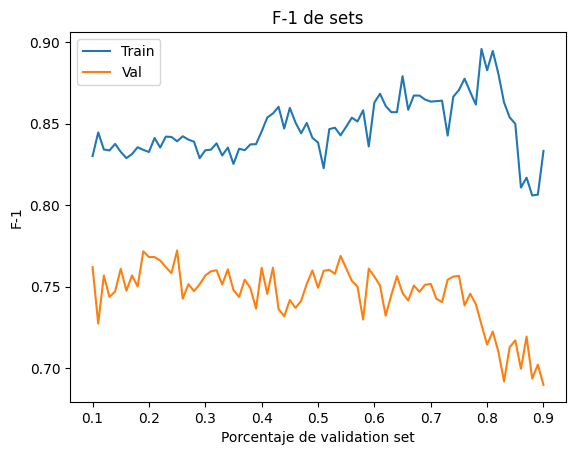

In [ ]:
# F-1
plt.plot(split, results_train['f-1'])
plt.plot(split, results_val['f-1'])
plt.legend(['Train','Val'])
plt.title('F-1 de sets')
plt.ylabel('F-1')
plt.xlabel('Porcentaje de validation set')
plt.show()

## Selección de porcentaje de separación

Error medio absoluto de las 4 métricas de aprendizaje por cada % de separación.

In [ ]:
abs(results_train - results_val).mean(axis = 1).sort_values(ascending = True).head(15)

9     0.061561
15    0.063738
41    0.065688
10    0.066483
5     0.068288
12    0.068939
0     0.069323
21    0.069327
24    0.070841
11    0.071233
20    0.071675
22    0.073161
7     0.073251
19    0.073373
25    0.073939
dtype: float64

Desviación standard de cada % de separación

In [ ]:
abs(results_train - results_val).std(axis = 1).sort_values().head(15)

30    0.010741
25    0.013429
74    0.013435
44    0.013953
27    0.014142
42    0.015150
40    0.015816
61    0.016900
24    0.017664
34    0.018228
20    0.019385
69    0.019849
45    0.020841
75    0.021075
43    0.021175
dtype: float64

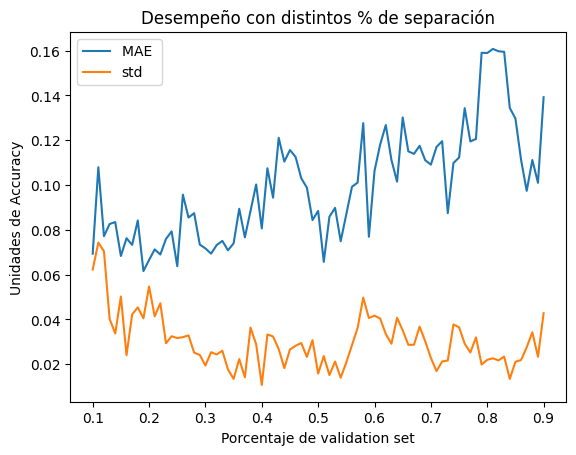

In [ ]:
plt.plot(split,abs(results_train - results_val).mean(axis = 1))
plt.plot(split,abs(results_train - results_val).std(axis = 1))
plt.legend(['MAE ','std'])
plt.title('Desempeño con distintos % de separación')
plt.ylabel('Unidades de Accuracy')
plt.xlabel('Porcentaje de validation set')
plt.show()

Para nuestro modelo queremos un desempeño donde la diferencia entre las métricas de entrenamiento y validación no tengan tanta variación entre ellas y que esta misma, sea alto para no caer en un caso de overfitting, pero tampoco tan alto que se tenga un caso de underfitting. El % de separación que cumple con esta lógica es el 34%

In [ ]:
split[24:25]

array([0.34])

Las métricas en los sets de entrenamiento y validación son las siguientes:

In [ ]:
results_train.loc[24]

Accuracy     0.885666
Precision    0.928962
Recall       0.758929
f-1          0.835381
Name: 24, dtype: float64

In [ ]:
results_val.loc[24]

Accuracy     0.831683
Precision    0.835052
Recall       0.698276
f-1          0.760563
Name: 24, dtype: float64

Observamos que aunque el modelo en training obtiene mejores resultados, en validación aún son buenos. Es por esto que para futuros análisis se escogerá este separación.

## Prueba

Se hicieron los estadísticos de prueba para obtener los valores de las predicciones usando el dataframe de test. Sin embargo, observamos que los estadísticos obtenidos tuvieron peores resultados que en el validation y en el train.

In [ ]:
# Predicciones
y_pred = model.predict(test)

# Métricas de aprendizaje
results = pd.DataFrame([[accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred), f1_score(y_test, y_pred)]])
results.columns = ['Accuracy', 'Precision','Recall','f-1']
results

,Accuracy,Precision,Recall,f-1
0,0.683453,0.569892,0.670886,0.616279


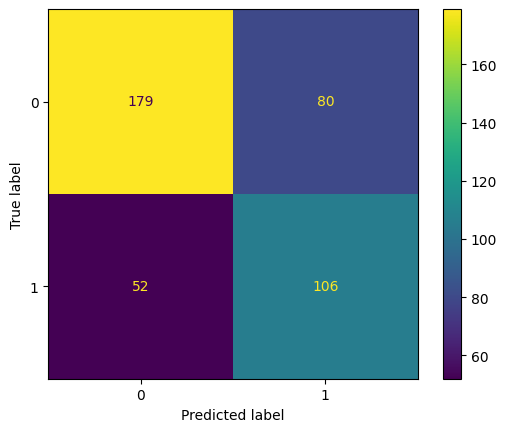

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()